## Tutorial 3: 1D diffusion equation
To solve the 1D diffusion equation using:
1. Explicit method
2. Implicit method
    - Thomas Algorithm
    - Iterative methods (Jacobi, Gauss-Seidel)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mesh_x = 100
timesteps = 100
dx = 1.0
dt = 0.4
Diffusivity = 1.0

In [3]:
x_array = np.arange(0, mesh_x, dx)

### Apply boundary condition at each timestep
Dirichlet boundary condition, where the value of c at the first and last point is fixed at all time steps.

In [4]:
def apply_BC(c):
    # Dirichlet (fixed) boundary condition
    c[0] = 0.0
    c[mesh_x-1] = 0.0
    return

### Explicit solution
$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2} $$
Let's have our discretized grid with mesh_x points, {0, 1, 2, ... mesh_x-2, mesh_x-1}.

For $ i \in [1, mesh\_x-2]$, 
$$ \frac{c^{t+1}_i - c^t_i}{\Delta t} = D \frac{ c^t_{i+1} - 2c^t_{i} + c^t_{i-1} }{{\Delta x}^2} = dc\_dt $$
$$ c^{t+1}_i =  c^t_i + \Delta t \; (dc\_dt) $$
For $ i == 0 $ and $ i == mesh\_x -1 $, we know the value of $c_i$ from the Dirichlet boundary condition.

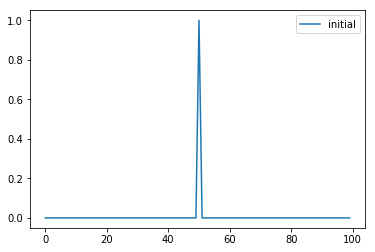

In [5]:
c_exp = np.zeros(mesh_x)
c_exp_new = np.zeros(mesh_x)
c_exp[mesh_x//2] = 1.0 # initialization
apply_BC(c_exp)

# plotting initial profile
plt.plot(x_array, c_exp, label='initial')
plt.legend()
plt.show()

In [6]:
# explicit solution
for t in range(timesteps):
    for i in range(1, mesh_x-1): # exclude the first and last point
        dc_dt = Diffusivity*( c_exp[i-1] - 2*c_exp[i] + c_exp[i+1] )/(dx**2)
        c_exp_new[i] = c_exp[i] + dc_dt*dt
    apply_BC(c_exp_new) # apply boundary condition at each time step
    c_exp = np.copy(c_exp_new) # copying updated values to c_exp

### implicit expression:
$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2} $$

$$ \frac{c^{t+1}_i - c^t_i}{\Delta t} = D \frac{ c^{t+1}_{i+1} - 2c^{t+1}_{i} + c^{t+1}_{i-1} }{{\Delta x}^2}$$
Let $ \alpha = \frac{D{\Delta t}}{{\Delta x}^2}$,
$$ -\alpha c_{i-1}^{t+1} + (1 + 2\alpha )c_i^{t+1} -\alpha c_{i+1}^{t+1} = c_i^t $$

In simpler terms,
$$ A_i c_{i-1}^{t+1} + B_i c_i^{t+1} + C_i c_{i+1}^{t+1} = D_i $$

### Implicit solution using Thomas Algorithm:
On rearranging the known terms in the previous expression to the RHS,

For $ i \in [2 \ldots mesh\_x-3]$, we have
$$ A_i = -\alpha, B_i = (1 + 2\alpha), C_i = -\alpha, D_i = c_i^t $$
For $ i == 1$
$$ A_i = 0, B_i = (1 + 2\alpha), C_i = -\alpha, D_i = c_i^t + \alpha c_0^t $$
For $ i == mesh\_x-2 $
$$ A_i = -\alpha, B_i = (1 + 2\alpha), C_i = 0, D_i = c_i^t + \alpha c_{mesh\_x-1}^t $$
#### First step: Forward elimination
$$ F = \frac{A_i}{B_i} $$
For $ i \in [2 \ldots mesh\_x-2]$,
$$ A_i = 0,\; B_i = B_i - F C_{i-1},\; D_i = D_i - F D_{i-1} $$

#### Second step: Backward substitution
For $ i == mesh\_x-2 $,
$$ c^{t+1}_{mesh\_x-2} = \frac{D_{mesh\_x-2}}{B_{mesh\_x-2}} $$
For $ i == [mesh\_x-3 \ldots 1] $,
$$ c^{t+1}_{i} = \frac{D_{i} - C_{i}c^{t+1}_{i+1}}{B_{i}} $$

In [7]:
c_imp = np.zeros(mesh_x)
A = np.zeros(mesh_x)
B = np.zeros(mesh_x)
C = np.zeros(mesh_x)
D = np.zeros(mesh_x)

c_imp[mesh_x//2] = 1.0 # initialization
apply_BC(c_imp)
alpha = Diffusivity*dt/(dx**2)
for t in range(timesteps):
    A[1:mesh_x-1] = -alpha
    B[1:mesh_x-1] = (1 + 2*alpha)
    C[1:mesh_x-1] = -alpha
    D[1:mesh_x-1] = c_imp[1:mesh_x-1]
    
    A[1] = 0.0
    D[1] = D[1] + alpha*c_imp[0]
    C[mesh_x-2] = 0.0
    D[mesh_x-2] = D[mesh_x-2] + alpha*c_imp[mesh_x-1]
    
    # forward elimination
    for i in range(2, mesh_x-1):
        F = A[i]/B[i-1]
        A[i] = 0.0
        B[i] = B[i] - F*C[i-1]
        D[i] = D[i] - F*D[i-1]
    
    # backward substitution
    c_imp[mesh_x-2] = D[mesh_x-2]/B[mesh_x-2]
    for i in range(mesh_x-3, 0, -1):
        c_imp[i] = (D[i] - C[i]*c_imp[i+1])/B[i]
    
    apply_BC(c_imp)

### Implicit solution using Iterative methods:
#### Jacobi solution
For $k^{th}$ iteration,
$$ c_{i(new)}^{k+1} = \frac{D_i - A_{i}c_{i-1}^k - C_{i}c_{i+1}^k}{B_i} $$ 

At end of each iteration,
$$c_i = c_{i(new)}$$

In [8]:
c_jac = np.zeros(mesh_x)
A = np.zeros(mesh_x)
B = np.zeros(mesh_x)
C = np.zeros(mesh_x)
D = np.zeros(mesh_x)

c_jac[mesh_x//2] = 1.0 # initialization
apply_BC(c_jac)
c_jac_new = np.copy(c_jac)
alpha = Diffusivity*dt/(dx**2)
total_iterations = 10 # total number of iterations
for t in range(timesteps):
    A[1:mesh_x-1] = -alpha
    B[1:mesh_x-1] = (1 + 2*alpha)
    C[1:mesh_x-1] = -alpha
    D[1:mesh_x-1] = c_jac[1:mesh_x-1]
    
    for iterations in range(total_iterations):
        for i in range(1, mesh_x-1):
            c_jac_new[i] = (D[i] - A[i]*c_jac[i-1] - C[i]*c_jac[i+1])/B[i]
        apply_BC(c_jac_new)
        # update c_jac each iteration
        c_jac = np.copy(c_jac_new)

### Implicit solution using Iterative methods:
#### Red Black Gauss Seidel
For $k^{th}$ iteration,

For $ i == even$,

$$ c_i^{k+1} = \frac{D_i - A_{i}c_{i-1}^k - C_{i}c_{i+1}^k}{B_i} $$ 

For $ i == odd$,

$$ c_i^{k+1} = \frac{D_i - A_{i}c_{i-1}^k - C_{i}c_{i+1}^k}{B_i} $$ 


In [9]:
c_rb = np.zeros(mesh_x)
A = np.zeros(mesh_x)
B = np.zeros(mesh_x)
C = np.zeros(mesh_x)
D = np.zeros(mesh_x)

c_rb[mesh_x//2] = 1.0 # initialization
apply_BC(c_rb)
alpha = Diffusivity*dt/(dx**2)
total_iterations = 10 # total number of iterations
for t in range(timesteps):
    A[1:mesh_x-1] = -alpha
    B[1:mesh_x-1] = (1 + 2*alpha)
    C[1:mesh_x-1] = -alpha
    D[1:mesh_x-1] = c_rb[1:mesh_x-1]
    
    for iterations in range(total_iterations):
        for i in range(1, mesh_x-1):
#             even points
            if i%2 == 0:
                c_rb[i] = (D[i] - A[i]*c_rb[i-1] - C[i]*c_rb[i+1])/B[i]
        apply_BC(c_rb)
        for i in range(1, mesh_x-1):
#             odd points
            if i%2 != 0:
                c_rb[i] = (D[i] - A[i]*c_rb[i-1] - C[i]*c_rb[i+1])/B[i]
        apply_BC(c_rb)

### plots

<IPython.core.display.Javascript object>


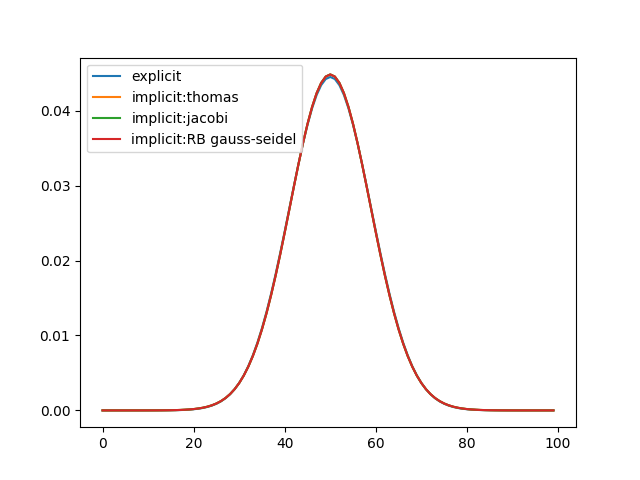

In [10]:
%matplotlib notebook
plt.plot(x_array, c_exp, label='explicit')
plt.plot(x_array, c_imp, label='implicit:thomas')
plt.plot(x_array, c_jac, label='implicit:jacobi')
plt.plot(x_array, c_rb, label='implicit:RB gauss-seidel')
# plt.ylim((-0.1, 0.2))
plt.legend()
plt.show()